In [22]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [23]:
# path to downloaded survey responses
survey_file = '/mnt/c/Users/taryn/OneDrive - UW/Documents/PugetSoundHousing/2022_ESS_Survey/2022_ESS_GraduateHousingSurvey.csv'

# year that survey was run
survey_year = 2022

# survey questions and corresponding shortened names (short names make data analysis way easier)
colnames = {
    'Timestamp': 'timestamp', 
    'Which degree option are you enrolled in?': 'program',
    'What year did you begin your current graduate program at UW?': 'cohort',
    'What is your typical monthly pre-tax income?': 'income_monthly',
    'Which of the following sources of income have you had while you have been a graduate student at UW?': 'income_sources',
    'Have you had a source of money other than from wages/salary while you have been a graduate student at UW?': 'income_altsources',
    'Do you share housing expenses with a partner?': 'income_shared',
    'Do you support dependents, family, or other people on your income?': 'income_support',
    'Is there anything else you would like to share about your income situation?': 'income_comments',
    'What city do you live in?': 'location_city',
    'Which Seattle neighborhood do you live in?': 'location_neighborhood',
    'If your neighborhood is commonly known by any other names besides the "official" designation, please describe them here.': 'location_altnames',
    'Would you recommend your neighborhood/city to other graduate students?': 'location_rating',
    'What are your favorite and/or least favorite aspects of your neighborhood/city?': 'location_comments',
    'Do you rent or own your residence?': 'cost_rentown',
    'How much do you (personally) pay in rent/mortgage each month?': 'cost_monthly',
    'Which utilities, if any, are included in your monthly rent/mortgage payment?': 'cost_utilitiesincl',
    'What is your average personal monthly cost of utilities that are paid separately from rent/mortgage, in dollars?': 'cost_utilities',
    'Do you have to pay any other regular monthly housing costs?': 'cost_other',
    'How many people live in your current residence? [.]': 'people_number',
    'Do you live with a partner, dependents, and/or other family members?': 'people_family',
    'Do you share the cost of a bedroom with another person?': 'cost_roomshare',
    'If you share housing costs with other people, what is the total monthly rent/mortgage of your entire residence?': 'cost_residence',
    'How concerned are you about your ability to afford housing currently?': 'cost_concern',
    'Is there anything else you would like to share about your housing costs?': 'cost_comments',
    'How many bedrooms are in your residence? [.]': 'housing_bedrooms',
    'How many bathrooms are in your residence?': 'housing_bathrooms',
    'What type of housing do you live in?': 'housing_type',
    'What kind of parking is available at your residence?': 'housing_parking',
    'What kind of laundry facilities does your residence have?': 'housing_laundry',
    'Does your residence allow pets?': 'housing_petsokay', 
    'Do you have or live with pets?': 'housing_havepets',
    'How would you rate the overall quality of your residence?': 'housing_quality',
    'Is there anything else you would like to share about your housing characteristics?': 'housing_comments',
    'How do you typically commute between home and campus?': 'commute_mode',
    'How many minutes does it typically take you to get between home and campus by bike?': 'commute_bike',
    'How many minutes does it typically take you to get between home and campus by walking?': 'commute_walk',
    'How many minutes does it typically take you to get between home and campus by car?': 'commute_car',
    'How many minutes does it typically take you to get between home and campus by public transit (bus, light rail, train, ferry)? Include time spent getting to/from your transit stops.': 'commute_transit',
    'If you take public transit, how many times do you typically need to transfer routes to get to campus?': 'commute_transfers',
    'If you take public transit, approximately how far away (walking time) is the stop that you typically use to commute to campus?': 'commute_stopdistance',
    'Do you own or have access to a car?': 'commute_havecar',
    'Is there anything else you would like to share about your commute?': 'commute_comments',
    'How many residences have you lived in since starting in your program?': 'history_numresidences',
    'How have you found your current and previous residences in the Puget Sound area?': 'history_howtofind',
    'Have you ever experienced a non-permanent living situation for an uncertain period of time, such as homelessness or extended couch-surfing, since you\'ve been a graduate student in ESS?': 'history_unhoused',
    'Do you have any other general recommendations or comments related to housing in the Puget Sound area that have not been addressed in this survey?': 'comments',
    'Do you have any feedback on this survey?': 'feedback'}

In [24]:
# read survey responses file and convert multiple-response (checkbox) answers to separate strings
responses = pd.read_csv(survey_file, converters={
    'Which utilities, if any, are included in your monthly rent/mortgage payment?': lambda x: x.split(';'),
    'Do you have to pay any other regular monthly housing costs?': lambda x: x.split(';'),
    'Which of the following sources of income have you had while you have been a graduate student at UW?': lambda x: x.split(';'),
    'What kind of parking is available at your residence?': lambda x: x.split(';'),
    'How do you typically commute between home and campus?': lambda x: x.split(';'),
    'How have you found your current and previous residences in the Puget Sound area?': lambda x: x.split(';')})

# rename columns from full questions to shortened column names (defined above)
responses = responses.rename(columns=colnames)

In [25]:
# read file of Seattle neighborhood boundaries
seattle_neighborhoods_file = '../SeattleNeighborhoods/SeattleNeighborhoods.shp'
seattle_neighborhoods = gpd.read_file(seattle_neighborhoods_file)
seattle_neighborhoods.drop(columns=['OBJECTID', 'AREA', 'PERIMETER', 'HOODS_', 'HOODS_ID', 'L_HOODID', 'SYMBOL', 'SYMBOL2', 'SHAPE_AREA', 'SHAPE_LEN'], inplace=True)

In [26]:
# Data cleaning

# -- create new column in seattle_neighborhoods for neighborhood name format in survey
seattle_neighborhoods['neighborhood'] = ''
for i in seattle_neighborhoods.index:
    s_hood = seattle_neighborhoods.loc[i].S_HOOD
    l_hood = seattle_neighborhoods.loc[i].L_HOOD
    if l_hood == 'CENTRAL AREA':
        l_hood = 'CENTRAL DISTRICT'
    if l_hood is not None and 'NO BROADER TERM' not in l_hood:
        seattle_neighborhoods['neighborhood'].loc[i] = (s_hood+' ('+l_hood.title()+')')
    else:
        seattle_neighborhoods['neighborhood'].loc[i] = s_hood
seattle_neighborhoods.at[seattle_neighborhoods[seattle_neighborhoods.neighborhood == 'University District (University District)'].index.values[0], 'neighborhood'] = 'University District'
# -- merge seattle neighborhoods geodataframe with raw responses
summary_responses = responses.groupby('location_neighborhood').mean()
summary_responses['totalnum'] = responses.location_neighborhood.value_counts()
geo_responses = seattle_neighborhoods.merge(summary_responses, left_on='neighborhood', right_on='location_neighborhood')

# replace convenience values from survey with sensible values
responses.people_number.replace('Just me', '1', inplace=True)
responses.housing_bedrooms.replace('Studio', '0', inplace=True)

# -- common dataframe subsets
doctoral = responses[responses.program == 'Doctoral']
message = responses[responses.program == 'MESSAGe']
renters = responses[responses.cost_rentown == 'Rent']
renters_soloroom = renters[renters.cost_roomshare == 'No']

# -- additional calculations
renters['cost_total'] = renters.cost_utilities + renters.cost_monthly
geo_responses = geo_responses.merge(renters.groupby('location_neighborhood').mean().cost_total, left_on='neighborhood', right_on='location_neighborhood')

# -- function warning for small number statistics
def statsWarning():
    print('<< Warning! Small number statistics! Use cautiously! >>')

# -- function for plotting neighborhood outlines
def showNeighborhoodOutlines(ax):
    seattle_neighborhoods.geometry.boundary.plot(ax=ax, edgecolor='black', color=None, linewidth=0.5)


/home/taryn/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-26-7c619916ec5b>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renters['cost_total'] = renters.cost_utilities + renters.cost_monthly



This survey received 31 responses.

Broken down by program:
Doctoral    30
MESSAGe      1

Broken down by cohort entry year:
2021    7
2020    7
2019    4
2018    4
2017    3
2016    6


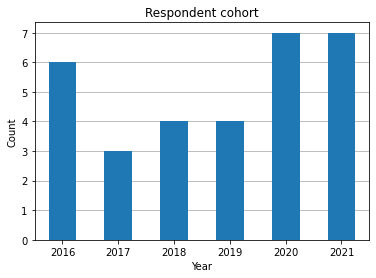

In [27]:
# SURVEY DEMOGRAPHICS

# How many people responded to the survey?
print('\nThis survey received {} responses.'.format(len(responses)))

# Break down responses by program
print('\nBroken down by program:')
print(responses.program.value_counts(dropna=False).to_string())

# Break down responses by cohort
print('\nBroken down by cohort entry year:')
print(responses.cohort.dropna().astype('int64').value_counts().sort_index(ascending=False).to_string())

# Plot cohort distribution
fig, ax = plt.subplots()
responses.cohort.dropna().astype('int64').value_counts().sort_index().plot.bar(ax=ax, rot=0, title='Respondent cohort', xlabel='Year', ylabel='Count', zorder=3)
ax.grid(axis='y', zorder=0)
plt.savefig('./cohort.png', bbox_inches='tight', dpi=300)


In [28]:
# LOCATION

print('\nLOCATION -----------------------------------------------------------|')

# Determine which cities people live in
print('\nRespondents live in the following cities:')
print(responses.location_city.value_counts(dropna=False, sort=True, ascending=False).to_string(na_rep='not provided', header=False))

# Calculate average rating for each city
print('\nThey rated their cities on a scale of 1 to 5, 5 being the best.')
print(responses.groupby('location_city').mean().location_rating.sort_values(ascending=False).to_string(float_format='%.1f', header=False))

# Determine which neighborhood people live in
print('\nRespondents in Seattle live in these neighborhoods:')
print(responses[responses.location_city == 'Seattle'].location_neighborhood.value_counts(dropna=False, sort=True, ascending=False).to_string(na_rep='not provided', header=False))

# Link to neighborhood reference
print('You can see these neighborhood designations at https://jterrace.github.io/seattle-neighborhoods/')

# Calculate average rating for each neighborhood
print('\nThey rated their neighborhoods on a scale of 1 to 5, 5 being the best:')
statsWarning()
print(responses[responses.location_city == 'Seattle'].groupby('location_neighborhood').mean().location_rating.sort_values(ascending=False).to_string(float_format='%.1f', header=False))



LOCATION -----------------------------------------------------------|

Respondents live in the following cities:
Seattle    31

They rated their cities on a scale of 1 to 5, 5 being the best.
Seattle   4.3

Respondents in Seattle live in these neighborhoods:
University District            5
Greenwood                      3
Wallingford                    3
Roosevelt                      3
Ravenna                        3
Fremont                        2
Adams (Ballard)                1
Wedgwood                       1
Montlake (Capitol Hill)        1
Matthews Beach (Lake City)     1
Pinehurst (Northgate)          1
Whittier Heights (Ballard)     1
Lawton Park (Magnolia)         1
Victory Heights (Lake City)    1
Bryant                         1
Stevens (Capitol Hill)         1
Sand Point                     1
Green Lake                     1
You can see these neighborhood designations at https://jterrace.github.io/seattle-neighborhoods/

They rated their neighborhoods on a scale of 1 t

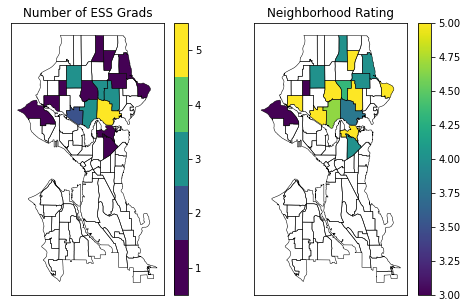

In [29]:
# Plot basic neighborhood info

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,5))
axs = axs.flatten()

# -- total number of students in each neighborhood
showNeighborhoodOutlines(axs[0])
geo_responses.plot(ax=axs[0], column='totalnum', cmap=plt.cm.get_cmap('viridis', geo_responses.totalnum.max()), legend=True, vmin=0.5, vmax=geo_responses.totalnum.max()+0.5)
axs[0].set_title('Number of ESS Grads')
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)

# -- average rating for each neighborhood
showNeighborhoodOutlines(axs[1])
geo_responses.plot(ax=axs[1], column='location_rating', legend=True)
axs[1].set_title('Neighborhood Rating')
axs[1].xaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

plt.savefig('./neighborhood.png', bbox_inches='tight', dpi=300)

In [30]:

print('\nCOSTS --------------------------------------------------------------|\n')

print('While some people do own houses in the area, most grad students rent. The following information pertains to renters.')

# Calculate average overall monthly rent, and for doctoral vs MESSAGe students
print('\nThe average monthly rent is ${:.2f}.'.format(renters.cost_monthly.mean()))
print('Doctoral students are paying ${:.2f} on average.'.format(renters[renters.program == 'Doctoral'].cost_monthly.mean()))
print('MESSAGe students are paying ${:.2f} on average.'.format(renters[renters.program == 'MESSAGe'].cost_monthly.mean()))

# Calculate average monthly rent for each neighborhood
print('\nThe average rent varies with city and neighborhood:')
statsWarning()
print('\nCity:\n'+renters.groupby('location_city').mean().cost_monthly.sort_values(ascending=False).to_string(
    float_format='$%.2f', header=False))
# print('\nSeattle Neighborhood:\n'+renters.groupby('location_neighborhood').mean().cost_monthly.sort_values(ascending=False).to_string(
    # float_format='$%.2f', header=False))
print('\nMost expensive Seattle neighborhoods:\n'+renters.groupby('location_neighborhood').mean().cost_monthly.sort_values(ascending=False).head(5).to_string(
    float_format='$%.2f', header=False))
print('\nLeast expensive Seattle neighborhoods:\n'+renters.groupby('location_neighborhood').mean().cost_monthly.sort_values(ascending=False).tail(5).to_string(
    float_format='$%.2f', header=False))

print('\nNote that the above numbers include people who share their rent with a partner. If we filter those numbers out:')
print('\nMost expensive Seattle neighborhoods:\n'+renters_soloroom.groupby('location_neighborhood').mean().cost_monthly.sort_values(ascending=False).head(5).to_string(
    float_format='$%.2f', header=False))
print('\nLeast expensive Seattle neighborhoods:\n'+renters_soloroom.groupby('location_neighborhood').mean().cost_monthly.sort_values(ascending=False).tail(5).to_string(
    float_format='$%.2f', header=False))



COSTS --------------------------------------------------------------|

While some people do own houses in the area, most grad students rent. The following information pertains to renters.

The average monthly rent is $925.16.
Doctoral students are paying $920.59 on average.
MESSAGe students are paying $1053.00 on average.

The average rent varies with city and neighborhood:
<< Warning! Small number statistics! Use cautiously! >>

City:
Seattle   $925.16

Most expensive Seattle neighborhoods:
Adams (Ballard)               $1152.00
Fremont                       $1057.50
Victory Heights (Lake City)   $1022.00
Sand Point                    $1000.00
Whittier Heights (Ballard)    $1000.00

Least expensive Seattle neighborhoods:
Stevens (Capitol Hill)       $822.00
Pinehurst (Northgate)        $800.00
Montlake (Capitol Hill)      $720.00
Wedgwood                     $585.00
Matthews Beach (Lake City)   $475.00

Note that the above numbers include people who share their rent with a partner. I

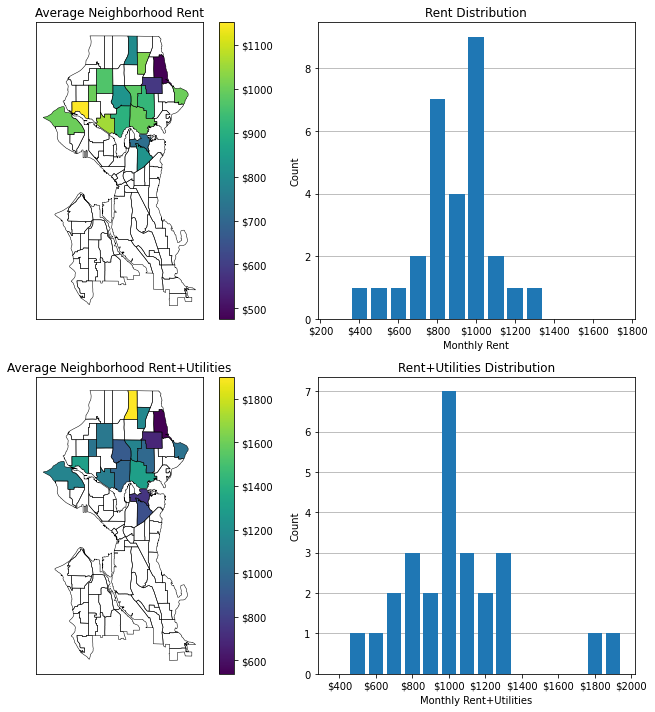

In [31]:
# Plot average rent

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axs = axs.flatten()
formatter = ticker.FormatStrFormatter('$%.0f')

# -- as map, average per neighborhood
showNeighborhoodOutlines(axs[0])
geo_responses.plot(ax=axs[0], column='cost_monthly', legend=True, legend_kwds={'format': '$%.0f'})
axs[0].set_title('Average Neighborhood Rent')
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)

# -- as histogram
axs[1].hist(renters.cost_monthly.values, rwidth=0.8, bins=list(range(300,1900,100)), align='left', zorder=3)
axs[1].set_title('Rent Distribution')
axs[1].set_xlabel('Monthly Rent')
axs[1].set_ylabel('Count')
axs[1].xaxis.set_major_formatter(formatter)
axs[1].grid(axis='y', zorder=0)

# -- as map, including utilities
showNeighborhoodOutlines(axs[2])
geo_responses.plot(ax=axs[2], column='cost_total', legend=True, legend_kwds={'format': '$%.0f'})
axs[2].set_title('Average Neighborhood Rent+Utilities')
axs[2].xaxis.set_visible(False)
axs[2].yaxis.set_visible(False)

# -- as histogram, including utilities
axs[3].hist(renters.cost_total.values, rwidth=0.8, bins=list(range(400,2100,100)), align='left', zorder=3)
axs[3].set_title('Rent+Utilities Distribution')
axs[3].set_xlabel('Monthly Rent+Utilities')
axs[3].set_ylabel('Count')
axs[3].xaxis.set_major_formatter(formatter)
axs[3].grid(axis='y', zorder=0)

plt.tight_layout()

plt.savefig('./rent.png', bbox_inches='tight', dpi=300)


In [32]:

print('\nThere is a lot of information that these numbers obscure. For instance, these reported rents may have utilities included, or could be split with a partner. Let''s dig deeper.')

# Cost as percent of income
print('\nOn average, students are paying {:.1f}% of their monthly income towards rent.'.format((100 * renters.cost_monthly / renters.income_monthly).replace(np.inf, 100).mean()))
print('Doctoral students are paying {:.1f}% of their income towards rent.'.format((100 * renters[renters.program == 'Doctoral'].cost_monthly / renters[renters.program == 'Doctoral'].income_monthly).replace(np.inf, 100).mean()))
print('MESSAGe students are paying {:.1f}% of their income towards rent.'.format((100 * renters[renters.program == 'MESSAGe'].cost_monthly / renters[renters.program == 'MESSAGe'].income_monthly).replace(np.inf, 100).mean()))

# Average cost of bedroom per number of rooms in residence
print('\nGenerally, the more rooms a home has, the cheaper a room is (i.e. living with roommates costs less).')
statsWarning()
print('Number of bedrooms:\n'+renters.groupby('housing_bedrooms')['cost_monthly'].mean().sort_index().to_string(float_format='$%.2f', header=False))

# Average total cost of residence per size of residence
print('\nThe total cost of a residence isn\'t always evenly divided between roommates (e.g. if some rooms are bigger than others). Here is the average total cost of residences based on size.')
statsWarning()
print('Number of bedrooms:\n'+renters.groupby('housing_bedrooms')['cost_residence'].mean().sort_index().to_string(float_format='$%.2f', header=False))

# How many people split cost of room with someone else (e.g. a partner)
print('\nAlso, many students split the cost of a room with someone else, such as a partner. {} respondents ({:.0f}%) reported sharing the cost of a room with someone else.'.format(renters.cost_roomshare.value_counts().Yes, 100*renters.cost_roomshare.value_counts(normalize=True).Yes))

# How many of these include utilities/which utilities are included
print('\nIt\'s important to note that some of these rent costs have utilities included.')
print('{:.0f}% of renters have NATURAL GAS included in their rent.'.format(100*sum(['Natural gas' in renters.cost_utilitiesincl.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% of renters have ELECTRICITY included in their rent.'.format(100*sum(['Electricity' in renters.cost_utilitiesincl.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% of renters have WATER/SEWER included in their rent.'.format(100*sum(['Water/sewer' in renters.cost_utilitiesincl.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% of renters have GARBAGE/RECYCLING/COMPOST included in their rent.'.format(100*sum(['Garbage/recycling/compost' in renters.cost_utilitiesincl.loc[i] for i in renters.index])/len(renters.index)))

# Adding the cost of other utilities, what are the new averages
print('\nOf course, utilities that aren\'t included in rent are still part of the monthly cost of housing. Let\'s revisit average monthly housing costs with utilities included.')
statsWarning()
print('\nThe average cost of utilities is ${:.2f}, and the average cost of rent+utilities is ${:.2f}.'.format(renters.cost_utilities.mean(), renters.cost_total.mean()))
print('\nCity:\n'+renters.groupby('location_city').mean().cost_total.sort_values(ascending=False).to_string(
    float_format='$%.2f', header=False))
print('\nSeattle Neighborhood:\n'+renters.groupby('location_neighborhood').mean().cost_total.sort_values(ascending=False).to_string(
    float_format='$%.2f', header=False))



There is a lot of information that these numbers obscure. For instance, these reported rents may have utilities included, or could be split with a partner. Lets dig deeper.

On average, students are paying 34.0% of their monthly income towards rent.
Doctoral students are paying 33.7% of their income towards rent.
MESSAGe students are paying 42.0% of their income towards rent.

Generally, the more rooms a home has, the cheaper a room is (i.e. living with roommates costs less).
<< Warning! Small number statistics! Use cautiously! >>
Number of bedrooms:
0    $805.00
1    $951.39
2    $981.29
3   $1025.00
4    $799.60
5    $966.67
6    $925.00
7    $720.00

The total cost of a residence isn't always evenly divided between roommates (e.g. if some rooms are bigger than others). Here is the average total cost of residences based on size.
<< Warning! Small number statistics! Use cautiously! >>
Number of bedrooms:
0        NaN
1   $1835.17
2   $2012.33
3   $2900.00
4   $4358.33
5   $5400.00
6 

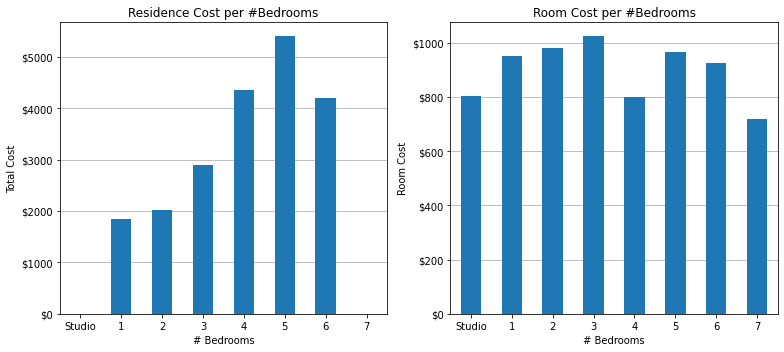

In [33]:
# Plot housing costs depending on number of bedrooms

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
axs = axs.flatten()
formatter = ticker.FormatStrFormatter('$%.0f')

# -- avg residence cost by size (# bedrooms)
renters.groupby('housing_bedrooms')['cost_residence'].mean().sort_index(ascending=True).plot.bar(ax=axs[0], title='Residence Cost per #Bedrooms', xlabel='# Bedrooms', ylabel='Total Cost', rot=0, zorder=3)
axs[0].yaxis.set_major_formatter(formatter)
axs[0].grid(axis='y', zorder=0)
labels = axs[0].get_xticklabels()
labels[0] = 'Studio'
axs[0].set_xticklabels(labels)

# -- avg bedroom cost by size (# bedrooms)
renters.groupby('housing_bedrooms')['cost_monthly'].mean().sort_index(ascending=True).plot.bar(ax=axs[1], title='Room Cost per #Bedrooms', xlabel='# Bedrooms', ylabel='Room Cost', rot=0, zorder=3)
axs[1].yaxis.set_major_formatter(formatter)
axs[1].grid(axis='y', zorder=0)
labels = axs[1].get_xticklabels()
labels[0] = 'Studio'
axs[1].set_xticklabels(labels)

plt.tight_layout()

plt.savefig('./size.png', bbox_inches='tight', dpi=300)



In [34]:
print('\nRent and utilities may be easy enough to figure out, but sometimes housing comes with additional costs.')

# Other monthly housing costs (parking, laundry, etc)
print('\nThere are other monthly housing-related costs that can add up, too.')
print('{:.0f}% of renters also pay for PARKING.'.format(100*sum(['Parking' in renters.cost_other.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% of renters also pay for LAUNDRY.'.format(100*sum(['Laundry' in renters.cost_other.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% of renters also pay for STORAGE.'.format(100*sum(['Storage' in renters.cost_other.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% of renters also pay for PET RENT.'.format(100*sum(['Pet rent' in renters.cost_other.loc[i] for i in renters.index])/len(renters.index)))

print('\nLiving in the Seattle area is expensive. On average, students ranked their concern about their ability to afford housing as {:.2f} out of 5, 5 being the highest.'.format(renters.cost_concern.mean()))

# Other comments
print('\nWhat else do we have to say about our housing costs?')
print('',*[n for n in responses.cost_comments if n is not np.nan], sep='\n-')



Rent and utilities may be easy enough to figure out, but sometimes housing comes with additional costs.

There are other monthly housing-related costs that can add up, too.
13% of renters also pay for PARKING.
33% of renters also pay for LAUNDRY.
3% of renters also pay for STORAGE.
10% of renters also pay for PET RENT.

Living in the Seattle area is expensive. On average, students ranked their concern about their ability to afford housing as 3.33 out of 5, 5 being the highest.

What else do we have to say about our housing costs?

-Rent was originally 895, but on two occasions my pipes burst and as a deal I got my rent reduced to 805 😎
-I think I got extremely lucky to find such a large house (6 bedrooms, 2 livingrooms, 2 kitchens, 2 car garage, fenced backyard, 3 additional parking spaces) in a desirable area for so little rent. I have the smallest room in the house, so I pay the least of the 4 of us living here, and the house is not without its own flaws (an unresponsive landlord be

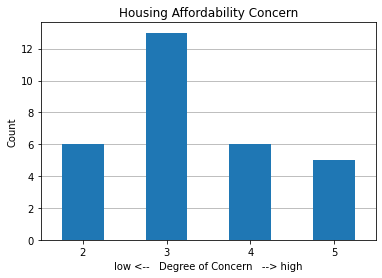

In [35]:
# Plot cost concerns

fig, ax = plt.subplots()
renters.cost_concern.value_counts().sort_index().plot.bar(ax=ax, rot=0, title='Housing Affordability Concern', xlabel='low <--   Degree of Concern   --> high', ylabel='Count', zorder=3)
ax.grid(axis='y', zorder=0)
plt.savefig('./affordability.png', bbox_inches='tight', dpi=300)

In [36]:

print('\nINCOME -------------------------------------------------------------|')

print('\nWe touched on cost as a percentage of income. Let''s check on the income sources people have to pay their rent. This is very different for funded research students vs the MESSAGe program.')

# Average monthly income
print('\nDoctoral students, on average, make ${:.2f} per month.'.format(doctoral.income_monthly.mean()))
print('MESSAGe students, on average, make ${:.2f} per month.'.format(message.income_monthly.mean()))

# Income sources
print('\nDoctoral students earn income from the following sources:')
print('{:.0f}% from TA/RA/GSA with tuition exemption'.format(100*sum(['TA/RA/GSA - with tuition exemption' in doctoral.income_sources.loc[i] for i in doctoral.index])/len(doctoral.index)))
print('{:.0f}% from TA/RA/GSA without tuition exemption'.format(100*sum(['TA/RA/GSA - without tuition exemption' in doctoral.income_sources.loc[i] for i in doctoral.index])/len(doctoral.index)))
print('{:.0f}% from UW hourly position'.format(100*sum(['UW hourly position' in doctoral.income_sources.loc[i] for i in doctoral.index])/len(doctoral.index)))
print('{:.0f}% from Fellowship/Traineeship'.format(100*sum(['Fellowship/Traineeship' in doctoral.income_sources.loc[i] for i in doctoral.index])/len(doctoral.index)))
print('{:.0f}% from Non-UW internship'.format(100*sum(['Non-UW internship' in doctoral.income_sources.loc[i] for i in doctoral.index])/len(doctoral.index)))
print('{:.0f}% from Non-UW position (as primary income source)'.format(100*sum(['Non-UW position - primary source of income' in doctoral.income_sources.loc[i] for i in doctoral.index])/len(doctoral.index)))
print('{:.0f}% from Non-UW position (as supplementary income source)'.format(100*sum(['Non-UW position - supplementary source of income' in doctoral.income_sources.loc[i] for i in doctoral.index])/len(doctoral.index)))
print('{:.0f}% have no income source'.format(100*sum(['None' in doctoral.income_sources.loc[i] for i in doctoral.index])/len(doctoral.index)))

print('\nMESSAGe students earn income from the following sources:')
print('{:.0f}% from TA/RA/GSA with tuition exemption'.format(100*sum(['TA/RA/GSA - with tuition exemption' in message.income_sources.loc[i] for i in message.index])/len(message.index)))
print('{:.0f}% from TA/RA/GSA without tuition exemption'.format(100*sum(['TA/RA/GSA - without tuition exemption' in message.income_sources.loc[i] for i in message.index])/len(message.index)))
print('{:.0f}% from UW hourly position'.format(100*sum(['UW hourly position' in message.income_sources.loc[i] for i in message.index])/len(message.index)))
print('{:.0f}% from Fellowship/Traineeship'.format(100*sum(['Fellowship/Traineeship' in message.income_sources.loc[i] for i in message.index])/len(message.index)))
print('{:.0f}% from Non-UW internship'.format(100*sum(['Non-UW internship' in message.income_sources.loc[i] for i in message.index])/len(message.index)))
print('{:.0f}% from Non-UW position (as primary income source)'.format(100*sum(['Non-UW position - primary source of income' in message.income_sources.loc[i] for i in message.index])/len(message.index)))
print('{:.0f}% from Non-UW position (as supplementary income source)'.format(100*sum(['Non-UW position - supplementary source of income' in message.income_sources.loc[i] for i in message.index])/len(message.index)))
print('{:.0f}% have no income source'.format(100*sum(['None' in message.income_sources.loc[i] for i in message.index])/len(message.index)))

# Alternate sources
print('\nSome students have alternate (non-work) sources of income, such as help from family, or student loans.')
print('{:.0f}% of doctoral students have an alternate source of financial support.'.format(100 * doctoral.income_altsources.value_counts().Yes / doctoral.income_altsources.count()))
# print('{:.0f}% of MESSAGe students have an alternate source of financial support.'.format(100 * message.income_altsources.value_counts().Yes / message.income_altsources.count()))

# Expenses shared
print('\nSome students share their expenses with a partner.')
print(responses.income_shared.value_counts().to_string(header=None))

# Supporting others on income
print('\nSometimes our income needs to support more than just ourselves. {:.0f}% of students support someone else (e.g. a dependent) on their income.'.format(100 * responses.income_support.value_counts().Yes / responses.income_support.count()))

# Other comments
print('\nWhat else do we have to say about our income as it relates to housing?')
print('',*[n for n in responses.income_comments if n is not np.nan], sep='\n-')



INCOME -------------------------------------------------------------|

We touched on cost as a percentage of income. Lets check on the income sources people have to pay their rent. This is very different for funded research students vs the MESSAGe program.

Doctoral students, on average, make $2746.70 per month.
MESSAGe students, on average, make $2510.00 per month.

Doctoral students earn income from the following sources:
93% from TA/RA/GSA with tuition exemption
3% from TA/RA/GSA without tuition exemption
17% from UW hourly position
37% from Fellowship/Traineeship
10% from Non-UW internship
3% from Non-UW position (as primary income source)
13% from Non-UW position (as supplementary income source)
0% have no income source

MESSAGe students earn income from the following sources:
100% from TA/RA/GSA with tuition exemption
0% from TA/RA/GSA without tuition exemption
0% from UW hourly position
0% from Fellowship/Traineeship
0% from Non-UW internship
0% from Non-UW position (as primary

In [37]:

print('\nHOUSEMATES ---------------------------------------------------------|')
print('\nWe saw that having more roommates tends to be cheaper. Let\'s look at how many people graduate student renters typically live with.')

# Number of housemates
print('\nTotal number of people living in household:\n'+renters.people_number.value_counts().sort_index(ascending=True).to_string(header=False))

# Live with a partner, dependents, other family
print('\nAdditionally, {:.0f}% of students who rent live with a partner, dependents, or other family.'.format(100 * renters.people_family.value_counts().Yes / renters.people_family.count()))



HOUSEMATES ---------------------------------------------------------|

We saw that having more roommates tends to be cheaper. Let's look at how many people graduate student renters typically live with.

Total number of people living in household:
1     4
2    13
3     3
4     2
5     7
8     1

Additionally, 37% of students who rent live with a partner, dependents, or other family.


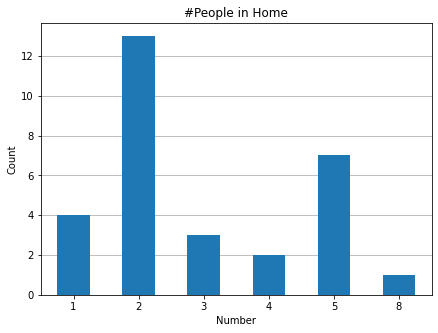

In [38]:
# Plot housemate numbers

fig, ax = plt.subplots(figsize=(7, 5))
renters.people_number.value_counts().sort_index(ascending=True).plot.bar(ax=ax, rot=0, title='#People in Home', ylabel='Count', xlabel='Number', zorder=3)
ax.grid(axis='y', zorder=0)
plt.savefig('./people.png', bbox_inches='tight', dpi=300)

In [39]:

print('\nHOUSING CHARACTERISTICS --------------------------------------------|')
print('\nLet\'s see what characteristics are typical of graduate student renter\'s homes.')

# Housing type
print('\nStudents live in a variety of housing types:\n'+renters.housing_type.value_counts().to_string(header=False))

# Number of bedrooms
print('\nWe live in a variety of home sizes.')
print('Number of bedrooms:\n'+renters.housing_bedrooms.value_counts().sort_index(ascending=True).to_string(header=False))

# Number of bathrooms
print('\nAnd most of us share bathrooms.')
print('Number of bathrooms:\n'+renters.housing_bathrooms.value_counts().sort_index(ascending=True).to_string(header=False))

# Parking available
print('\nThere are so many possible parking situations!')
print('{:.0f}% have free street parking'.format(100*sum(['Free street parking' in renters.housing_parking.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% have a free reserved spot (e.g. in garage)'.format(100*sum(['Free reserved spot (e.g. in garage)' in renters.housing_parking.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% have restricted street parking (e.g. need city permit)'.format(100*sum(['Restricted street parking (e.g. need city permit)' in renters.housing_parking.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% have a paid reserved spot'.format(100*sum(['Paid reserved spot' in renters.housing_parking.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% have no parking available'.format(100*sum(['No parking available' in renters.housing_parking.loc[i] for i in renters.index])/len(renters.index)))

# Laundry facilities
print('\nMost of us can do laundry at home.\n'+renters.housing_laundry.value_counts().to_string(header=False))

# Pets allowed
print('\nThe majority of rentals allow pets, too.\n'+renters.housing_petsokay.value_counts().to_string(float_format='%.0f', header=False))
print('And {:.0f}% of graduate students do have pets!'.format(100*renters.housing_havepets.value_counts(normalize=True).Yes))

# Overall quality of home
print('\nOverall, we think our homes are alright!\n'+renters.housing_quality.value_counts().to_string(header=False))

# Other comments
print('\nWhat else do we have to say about our housing itself?')
print('',*[n for n in responses.housing_comments if n is not np.nan], sep='\n-')


HOUSING CHARACTERISTICS --------------------------------------------|

Let's see what characteristics are typical of graduate student renter's homes.

Students live in a variety of housing types:
Apartment                       14
House                           10
Townhouse / duplex / similar     5
Condominium                      1

We live in a variety of home sizes.
Number of bedrooms:
0    1
1    9
2    7
3    3
4    5
5    3
6    1
7    1

And most of us share bathrooms.
Number of bathrooms:
1    15
2     6
3     9

There are so many possible parking situations!
57% have free street parking
40% have a free reserved spot (e.g. in garage)
20% have restricted street parking (e.g. need city permit)
33% have a paid reserved spot
0% have no parking available

Most of us can do laundry at home.
Washer/dryer provided in unit                                      18
Shared laundry facilities on site                                  10
No laundry facilities available                       

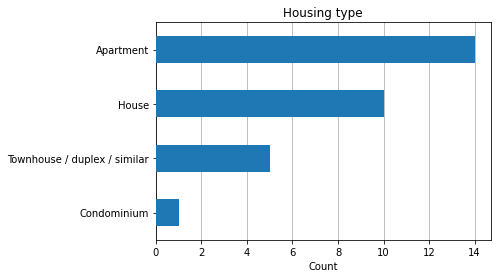

In [40]:
fig, ax = plt.subplots()
renters.housing_type.value_counts(ascending=True).plot.barh(ax=ax, title='Housing type', zorder=3)
ax.set_xlabel('Count')
ax.grid(axis='x', zorder=0)
plt.savefig('./housingtype.png', bbox_inches='tight', dpi=300)

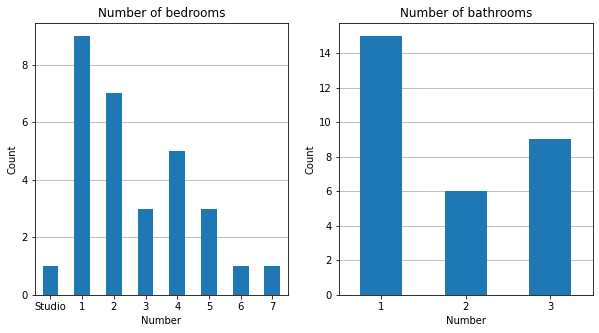

In [41]:
# Plot number of bedrooms and bathrooms

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs = axs.flatten()

# -- Number of bedrooms
renters.housing_bedrooms.value_counts().sort_index().plot.bar(ax=axs[0], rot=0, title='Number of bedrooms', ylabel='Count', xlabel='Number', zorder=3)
axs[0].grid(axis='y', zorder=0)
labels = axs[0].get_xticklabels()
labels[0] = 'Studio'
axs[0].set_xticklabels(labels)

# -- Number of bathrooms
renters.housing_bathrooms.value_counts().sort_index().plot.bar(ax=axs[1], rot=0, title='Number of bathrooms', ylabel='Count', xlabel='Number', zorder=3)
axs[1].grid(axis='y', zorder=0)

plt.savefig('./housing_bedbath.png', bbox_inches='tight', dpi=300)

In [42]:
print('Of the {} people who live in 1-bedroom homes, {} share their expenses with a partner.'.format(len(renters[renters.housing_bedrooms=='1']), len(renters[(renters.housing_bedrooms=='1') & (renters.income_shared!='No')])))

Of the 9 people who live in 1-bedroom homes, 6 share their expenses with a partner.


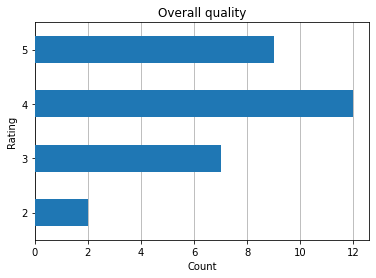

In [43]:
fig, ax = plt.subplots()
renters.housing_quality.value_counts().sort_index(ascending=True).plot.barh(ax=ax, title='Overall quality', zorder=3)
ax.set_ylabel('Rating')
ax.set_xlabel('Count')
ax.grid(axis='x', zorder=0)
plt.savefig('./housing_quality.png', bbox_inches='tight', dpi=300)

In [44]:
# Commute
print('\nCOMMUTE ------------------------------------------------------------|')
print('\nHow do graduate students get to campus, and how long does it take?')

# Commute mode
print('\nWe use a variety of commute modes to get to campus.')
print('{:.0f}% take the bus.'.format(100*sum(['Bus' in responses.commute_mode.loc[i] for i in responses.index])/len(responses.index)))
print('{:.0f}% take light rail.'.format(100*sum(['Light rail' in responses.commute_mode.loc[i] for i in responses.index])/len(responses.index)))
print('{:.0f}% bike.'.format(100*sum(['Bike' in responses.commute_mode.loc[i] for i in responses.index])/len(responses.index)))
print('{:.0f}% walk.'.format(100*sum(['Walk' in responses.commute_mode.loc[i] for i in responses.index])/len(responses.index)))
print('{:.0f}% drive alone.'.format(100*sum(['Drive (alone)' in responses.commute_mode.loc[i] for i in responses.index])/len(responses.index)))
print('{:.0f}% carpool.'.format(100*sum(['Drive (carpool)' in responses.commute_mode.loc[i] for i in responses.index])/len(responses.index)))

# Neighborhood -> average bike time
print('\nHere is the average bike commute time from different neighborhoods:')
print(responses.groupby('location_neighborhood')['commute_bike'].mean().dropna().sort_values().to_string(float_format='%.0f', header=None))

# Neighborhood -> average walk time
print('\nHere is the average walk commute time from different neighborhoods:')
print(responses.groupby('location_neighborhood')['commute_walk'].mean().dropna().sort_values().to_string(float_format='%.0f', header=None))

# Neighborhood -> average car time
print('\nHere is the average drive commute time from different neighborhoods:')
print(responses.groupby('location_neighborhood')['commute_car'].mean().dropna().sort_values().to_string(float_format='%.0f', header=None))

# Neighborhood -> average transit time
print('\nHere is the average transit commute time from different neighborhoods:')
print(responses.groupby('location_neighborhood')['commute_transit'].mean().dropna().sort_values().to_string(float_format='%.0f', header=None))

# Neighborhood -> number of transit stops
print('\nHere is the average number of transit transfers from different neighborhoods:')
print(responses.groupby('location_neighborhood')['commute_transfers'].mean().dropna().sort_values().to_string(float_format='%.0f', header=None))

# Distance to transit stop
print('\nHere is the typical distance from home to a transit stop in different neighborhoods:')
print(responses.groupby('location_neighborhood')['commute_stopdistance'].value_counts().to_string(header=None))
# TODO: in survey change this to numerical value input (range slider?)

# Have a car or not
print('\nAlthough most of us do not drive to campus, many of us do have cars.')
print(responses.commute_havecar.value_counts().to_string(header=None))

# Other comments
print('\nWhat else do we have to say about our commutes?')
print('', *[n for n in responses.commute_comments if n is not np.nan], sep='\n-')



COMMUTE ------------------------------------------------------------|

How do graduate students get to campus, and how long does it take?

We use a variety of commute modes to get to campus.
61% take the bus.
16% take light rail.
55% bike.
48% walk.
16% drive alone.
3% carpool.

Here is the average bike commute time from different neighborhoods:
Montlake (Capitol Hill)       6
Ravenna                      10
Wallingford                  12
Bryant                       15
Sand Point                   16
Roosevelt                    17
Fremont                      20
Greenwood                    25
Lawton Park (Magnolia)       30
Matthews Beach (Lake City)   30
Pinehurst (Northgate)        30
Stevens (Capitol Hill)       30

Here is the average walk commute time from different neighborhoods:
Montlake (Capitol Hill)   12
University District       18
Ravenna                   22
Wallingford               30
Roosevelt                 42
Fremont                   50
Greenwood               

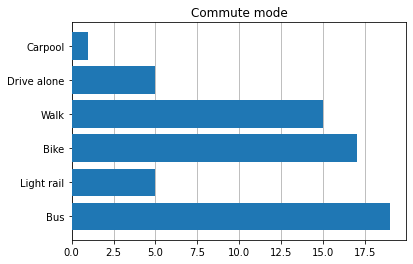

In [45]:
commute_mode = {'Bus': sum(['Bus' in i for i in responses.commute_mode]),
                'Light rail': sum(['Light rail' in i for i in responses.commute_mode]),
                'Bike': sum(['Bike' in i for i in responses.commute_mode]),
                'Walk': sum(['Walk' in i for i in responses.commute_mode]),
                'Drive alone': sum(['Drive (alone)' in i for i in responses.commute_mode]),
                'Carpool': sum(['Drive (carpool)' in i for i in responses.commute_mode])}

fig, ax = plt.subplots()
ax.barh(list(commute_mode.keys()), commute_mode.values(), zorder=3)
ax.set_title('Commute mode')
ax.grid(axis='x', zorder=0)
plt.savefig('./commute_mode.png', bbox_inches='tight', dpi=300)

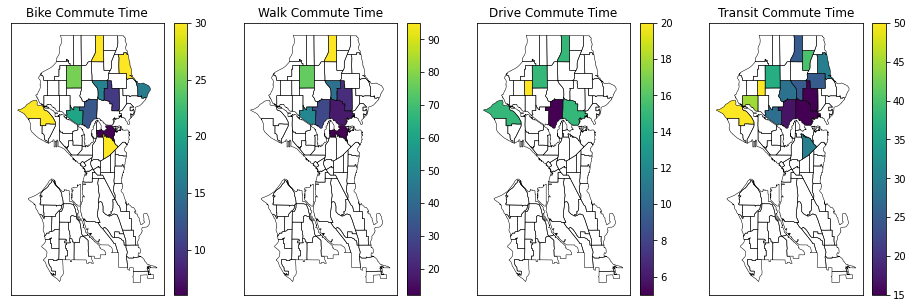

In [46]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 5))
axs = axs.flatten()

showNeighborhoodOutlines(axs[0])
geo_responses.plot(ax=axs[0], column='commute_bike', legend=True)
axs[0].set_title('Bike Commute Time')
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)

showNeighborhoodOutlines(axs[1])
geo_responses.plot(ax=axs[1], column='commute_walk', legend=True)
axs[1].set_title('Walk Commute Time')
axs[1].xaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

showNeighborhoodOutlines(axs[2])
geo_responses.plot(ax=axs[2], column='commute_car', legend=True)
axs[2].set_title('Drive Commute Time')
axs[2].xaxis.set_visible(False)
axs[2].yaxis.set_visible(False)

showNeighborhoodOutlines(axs[3])
geo_responses.plot(ax=axs[3], column='commute_transit', legend=True)
axs[3].set_title('Transit Commute Time')
axs[3].xaxis.set_visible(False)
axs[3].yaxis.set_visible(False)

plt.savefig('./commute_time.png', bbox_inches='tight', dpi=300)

Where should you look to find housing? Here are our recommendations:


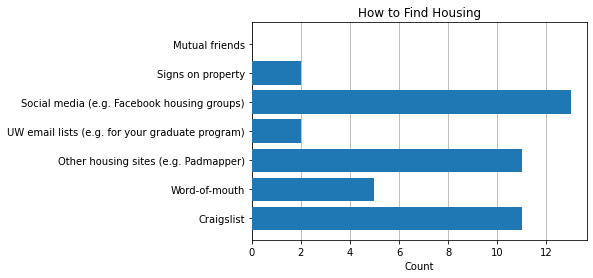

In [47]:
print('Where should you look to find housing? Here are our recommendations:')

how_to_find = {'Craigslist': sum(['Craigslist' in i for i in renters.history_howtofind]),
               'Word-of-mouth': sum(['Word-of-mouth' in i for i in renters.history_howtofind]),
               'Other housing sites (e.g. Padmapper)': sum(['Other housing sites (e.g. Padmapper)' in i for i in renters.history_howtofind]),
               'UW email lists (e.g. for your graduate program)': sum(['UW email lists (e.g. for your graduate program)' in i for i in renters.history_howtofind]),
               'Social media (e.g. Facebook housing groups)': sum(['Social media (e.g. Facebook housing groups)' in i for i in renters.history_howtofind]),
               'Signs on property': sum(['Signs on property' in i for i in renters.history_howtofind]),
               'Mutual friends': sum(['mutual friends' in i for i in renters.history_howtofind])}

fig, ax = plt.subplots()
ax.barh(list(how_to_find.keys()), how_to_find.values(), zorder=3)
ax.set_title('How to Find Housing')
ax.set_xlabel('Count')
ax.grid(axis='x', zorder=0)
plt.savefig('./search.png', bbox_inches='tight', dpi=300)

In [48]:
print('You might also be wondering how often people move while they\'re here. Excluding first-year students who haven\'t been here long, students average {:.0f} years in a home before moving.'.format(((survey_year - renters[(survey_year - renters.cohort) != 1.0].cohort) / renters[(survey_year - renters.cohort) != 1.0].history_numresidences).mean()))

You might also be wondering how often people move while they're here. Excluding first-year students who haven't been here long, students average 2 years in a home before moving.


In [49]:
print('{} students reported that they have been unhoused at some point during their time as a grad student.'.format(sum(renters.history_unhoused == 'Yes')))

5 students reported that they have been unhoused at some point during their time as a grad student.


In [50]:
# Other comments
print('\nWhat other comments do we have about housing in the Puget Sound area?')
print('',*[n for n in responses.comments if n is not np.nan], sep='\n-')


What other comments do we have about housing in the Puget Sound area?

-Spending extra $ is worth it... trust me. 
-Craigslist is good for cheaper houses, since Zillow tells landlords how much they could reasonably charge
